# Kalman Filter

Consider the following linear hidden Markov model:
\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0), \\
\tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; A x_{t-1}, Q), \\
g(y_t | x_t) &= \mathcal{N}(y_t; H x_t, R).
\end{align*}

Assume $T$ is fixed, and we have $ m_0 = 0, P_0 = 1, A = 0.9,
Q = 0.01, H = 1, R = 0.1 $

Assume $y_1, \dots, y_T$ is observed, and we want to infer 
on the latent $x_0 \dots x_T$  
In particular, we want to sample from posterior $p(x_{0:n}|y_{1:n})$
at each timestamp $n$

## Simulation of True Path

We simulate $ x_0 \sim \mathcal{N}(m_0, P_0) $

for t = 1, 2, .., T:  
- Simulate $ x_t \sim \mathcal{N}(A x_{t-1}, Q) $  
- Simulate $ y_t \sim \mathcal{N}(H x_{t}, R) $  

return $ x_{0:T}, y_{1:T} $



In [1]:
import numpy as np
import matplotlib.pyplot as plt

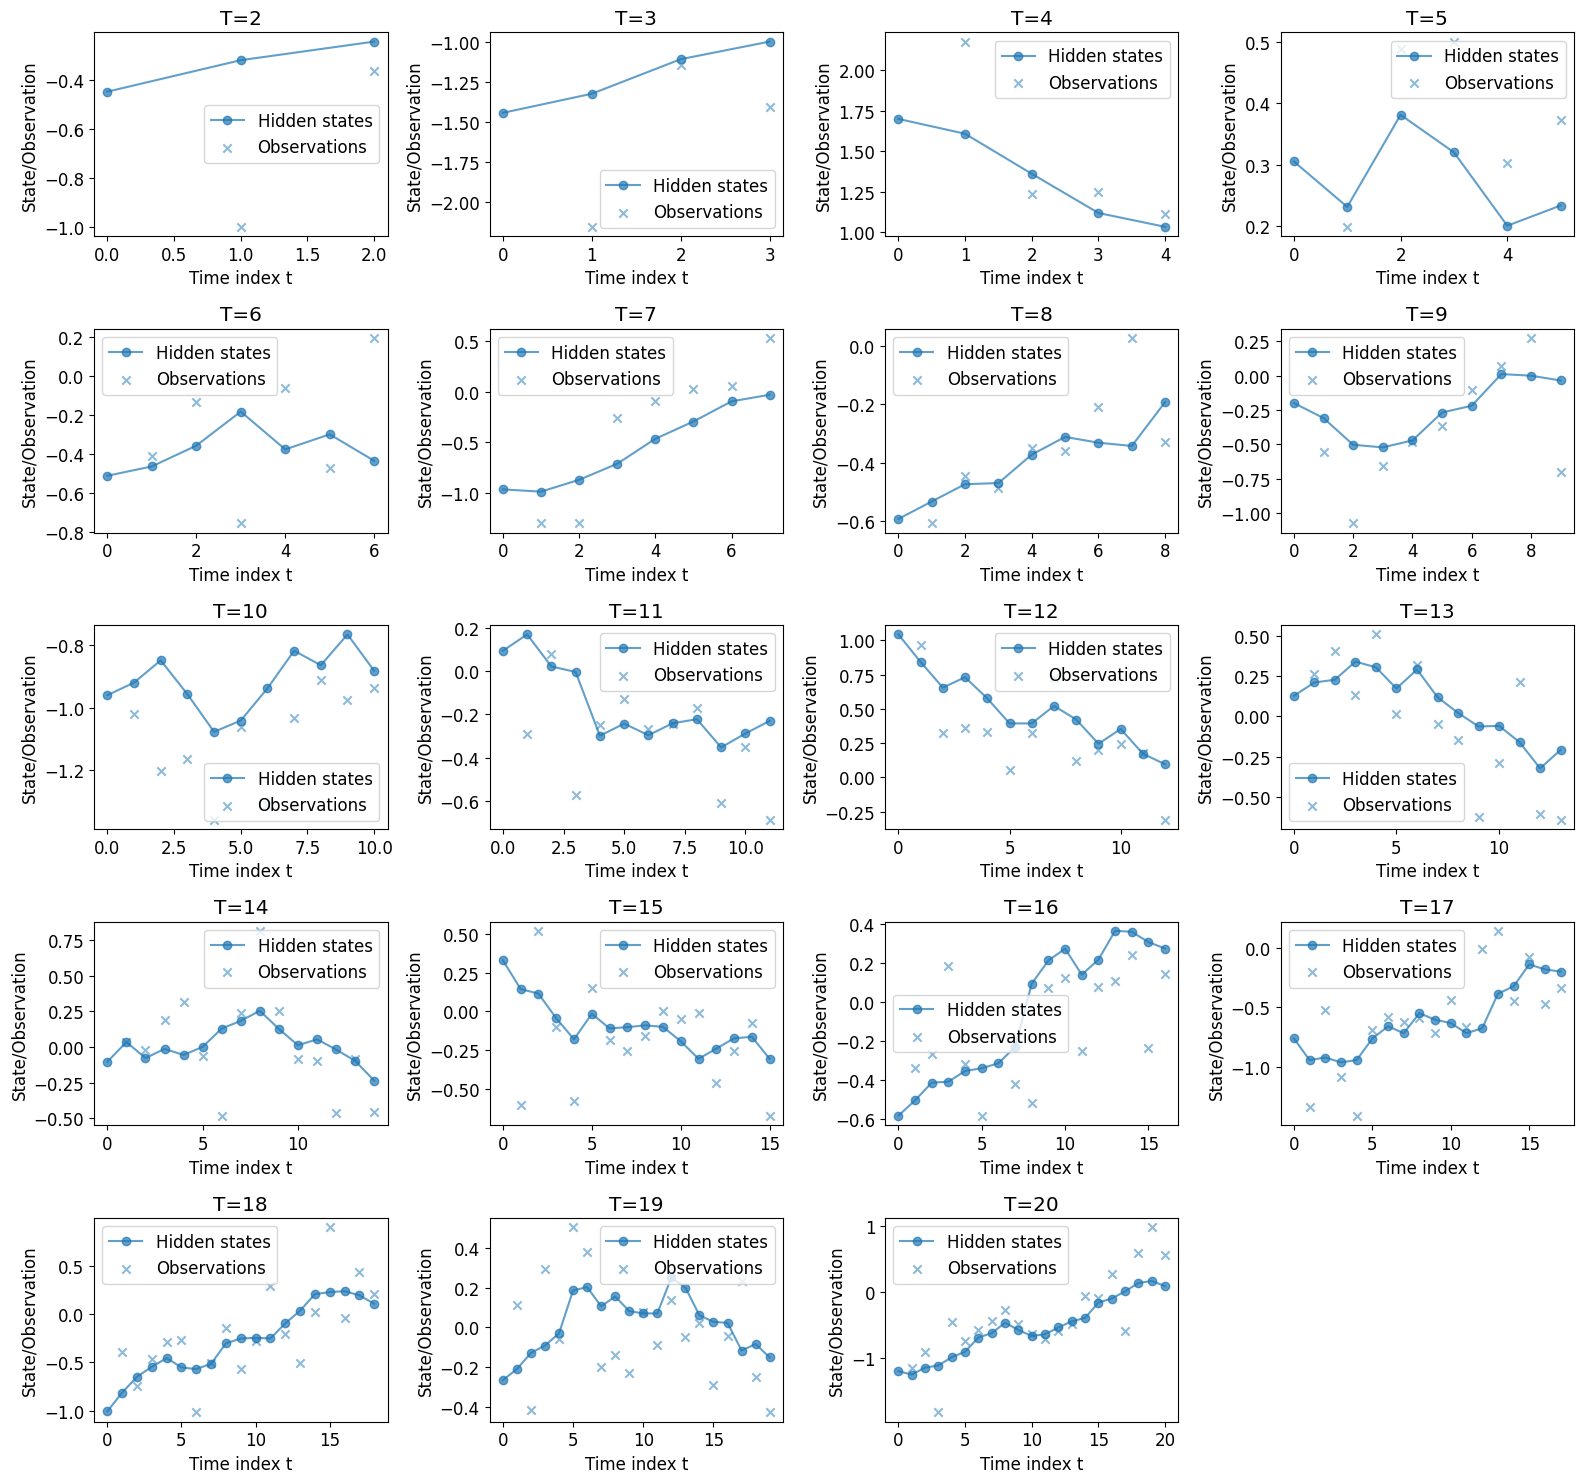

In [22]:

plt.rcParams.update({'font.size': 12})  # Set font size

def simulate_hmm(T, m0=0, P0=1, A=0.9, Q=0.01, H=1, R=0.1):
    """Simulate data from a linear-Gaussian HMM"""
    # Initialize state sequence
    x = np.zeros(T+1)
    y = np.zeros(T)
    
    # Sample initial state
    x[0] = np.random.normal(m0, np.sqrt(P0))
    
    # Generate state and observation sequences
    for t in range(1, T+1):
        x[t] = np.random.normal(A * x[t-1], np.sqrt(Q))
        y[t-1] = np.random.normal(H * x[t], np.sqrt(R))
    
    return x, y

datasets = {} # save for each T

# Simulate and plot for T = 2 to 20

# Initialize figure with 5 rows and 4 columns
fig, axes = plt.subplots(5, 4, figsize=(16, 15))
axes = axes.flatten()  # Flatten to easily iterate

for idx, T in enumerate(range(2, 21)):
    ds = {}
    x, y = simulate_hmm(T)
    
    ax = axes[idx]  # Select corresponding subplot

    # x has an extra x_0, so we use range(T+1)
    ax.plot(range(T+1), x, label="Hidden states", 
            alpha=0.7, linestyle='-', marker='o')

    ax.scatter(range(1, T+1), y, alpha=0.5, 
               marker='x', label="Observations")

    ax.set_title(f"T={T}")
    ax.set_xlabel("Time index t")
    ax.set_ylabel("State/Observation")
    ax.legend()

    # Save dataset
    ds[0] = x
    ds[1] = y
    datasets[T] = ds

# Remove any empty subplots (if necessary)
for i in range(len(range(2, 21)), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Apply Kalman Filter and Smoother

Note the filter estimates the current state $\pi_n(x_n | y_{1:n})$ in real time, using observations up to the present moment.

The smoother can be used to obtain most accurate estimate of all past states $\pi_n(x_i | y_{1:T})$, given observations up to now.

### Algorithm

Now for each T, we want to estimate the sequence of 
posterior mean $\{m_i^T\}_{i = 0, \dots T}$,   
where $ m_i^T =  E [x_i | y_{1:T} ] $, 

Recall our setup:

$$
p(x_0) = \mathcal{N}(x_0; m_0, P_0)
$$

$$
\tau(x_n | x_{n-1}) = \mathcal{N}(x_n; A x_{n-1}, Q)
$$

$$
g(y_n | x_n) = \mathcal{N}(y_n; H x_n, R)
$$

Note with Kalman filter, we can obtain $ \pi_n(x_n | y_{1:n}) = \mathcal{N}(x_n ; m_n, P_n) , n \leq T$  
so we know the filtering mean $ m_t = E [ x_t | y_{1:t} ]$
for each $ t = 1, 2, \dots T $.   

i.e. we can obtain $m_2 = E[x_2 | y_1, y_2]$ but not $m_1^{(2)} = E[x_1 | y_1, y_2]$

To obtain $ m_{0:T}^{(T)} $, 
we addtionally apply the smoother on top of the filter.

We reference the Kalman filter and smoother pesudocode from the lecture notes:

1. **Input:** starting point $ m_0=0, P_0=1 $, and the sequence of observations $ y_{1:T} $ for the specific T.
2. **Filtering**  
**For** $ n = 1, \dots, T $ **do**
   - **Prediction step:**
    $$
     \bar{m}_n = A m_{n-1} = 0.9 m_{n-1}
    $$
    $$
     \bar{P}_n = A P_{n-1} A^T + Q = 0.81 P_{n-1} + 0.01
    $$
   - **Update step:**
    $$
     K_n = \bar{P}_n H^T (H \bar{P}_n H^T + R)^{-1}
    $$

    $$
     m_n = \bar{m}_n + K_n (y_n - H \bar{m}_n)
    $$

    $$
     P_n = \bar{P}_n - K_n H \bar{P}_n = \bar{P}_n - K_n \bar{P}_n
    $$

**End for**    
We obtained $ m_{0:T}, P_{0:T}, \bar{m}_{1:T}, \bar{P}_{1:T}$

3. **Smoothing**    
Set $ m_T^s, P_T^s = m_T, P_T $

    **For** $ k = T-1 , \dots, 0 $ **do**  
    -  **Compute smoother gain:**    
        $$
        G_k = P_k A_k^T \bar{P}_{k+1}^{-1}
        $$
    - **Compute smoother mean**
        $$
        m_k^s = m_k + G_k (m_{k+1}^s - \bar{m}_{k+1} )
        $$
    - **Compute smoother covariance**
        $$
        P_k^s = P_k + G_k (P_{k+1}^s - \bar{P}_{k+1} ) G_k^T
        $$
    **End for**   



4. **Return** $ m^s_{0:T} $, the smoother mean

### Running for T = 2, ..., 20

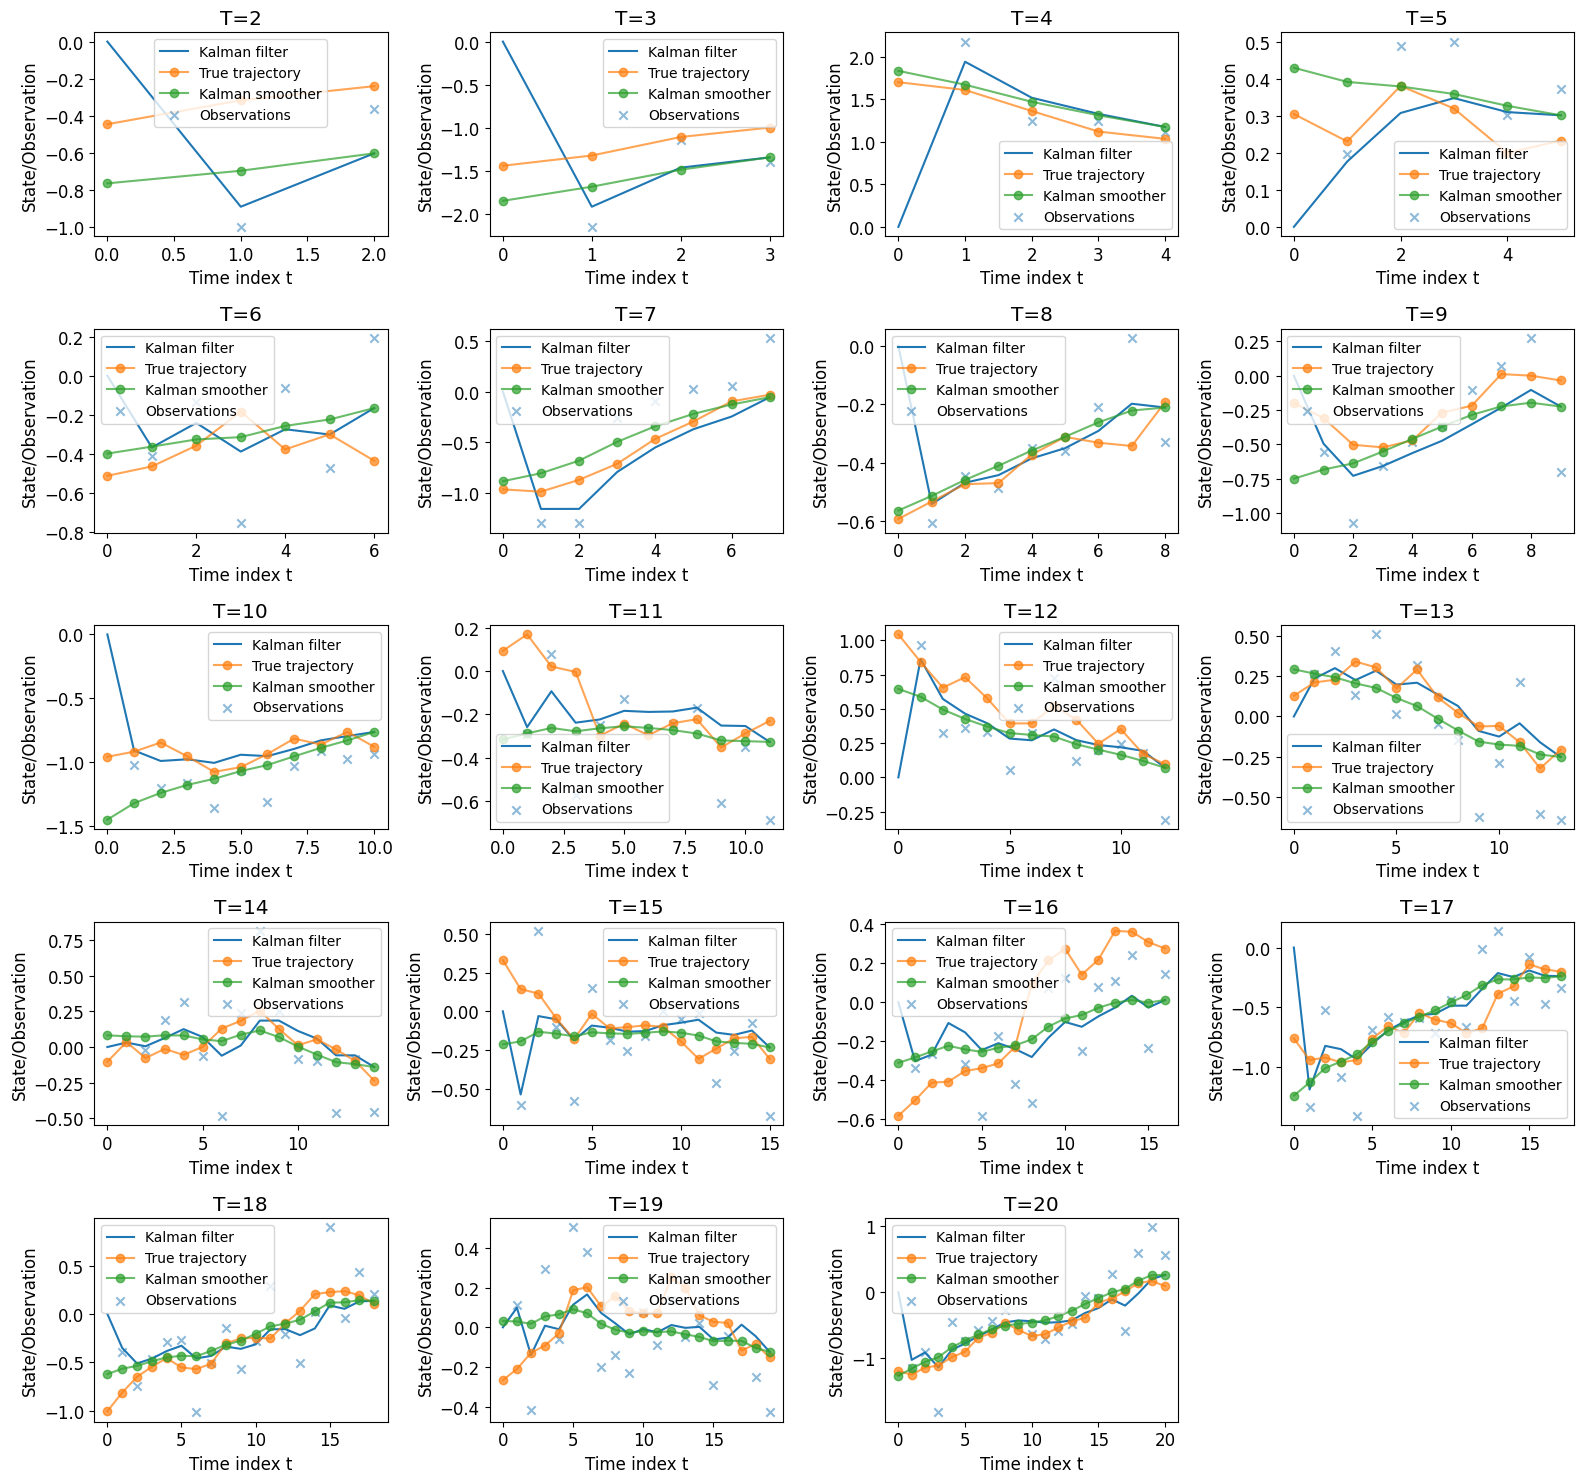

In [23]:

def kalman(T, m0=0, P0=1, A=0.9, Q=0.01, H=1, R=0.1):
    '''Implement Kalman filter and smoother for given data'''
    ds = datasets[T] # fetch saved dataset
    x, y = ds[0], ds[1]
    m = np.zeros(T)
    P = np.zeros(T)

    m_pred = np.zeros(T)
    P_pred = np.zeros(T)

    # First step
    m_pred[0] = A * m0
    P_pred[0] = A * P0 * A + Q

    K = P_pred[0] * H / (H * P_pred[0] * H + R)
    m[0] = m_pred[0] + K * (y[0] - H * m_pred[0])
    P[0] = P_pred[0] - K * H * P_pred[0]

    # Filtering loop
    for t in range(1, T):
        m_pred[t] = A * m[t - 1]
        P_pred[t] = A * P[t - 1] * A + Q
        
        K = P_pred[t] * H / (H * P_pred[t] * H + R)
        m[t] = m_pred[t] + K * (y[t] - H * m_pred[t])
        P[t] = P_pred[t] - K * H * P_pred[t]
    
    # Kalman Smoother
    m_smooth = np.zeros(T)
    P_smooth = np.zeros(T)

    m_smooth[-1] = m[-1]
    P_smooth[-1] = P[-1]

    for t in range(T-2, -1, -1):
        J = P[t] * A / P_pred[t+1]
        m_smooth[t] = m[t] + J * (m_smooth[t+1] - m_pred[t+1])
        P_smooth[t] = P[t] + J * (P_smooth[t+1] - P_pred[t+1]) * J

    J = P0 * A / P_pred[0]
    m_smooth_0 = m0 + J * (m_smooth[0] - m_pred[0])
    P_smooth_0 = P0 + J * (P_smooth[0] - P_pred[0]) * J

    m_smooth = np.concatenate(([m_smooth_0], m_smooth))
    m = np.concatenate(([m0], m))

    # note m_smooth is our estimate of the posterior mean
    # m is the kalman filter estimate
    return x, y, m, m_smooth

fig, axes = plt.subplots(5, 4, figsize=(16, 15))
axes = axes.flatten()  # Flatten to easily iterate

m_smooths = {} # save estimates for each T

for idx, T in enumerate(range(2, 21)):
    x, y, m, m_smooth = kalman(T)
    m_smooths[T] = m_smooth
    ax = axes[idx]  # Select corresponding subplot
    ax.plot(range(T+1), m, label="Kalman filter")

    ax.plot(range(T+1), x, label="True trajectory", 
            alpha=0.7, linestyle='-', marker='o')
    
    ax.plot(range(T+1), m_smooth, label="Kalman smoother",
            alpha=0.7, linestyle='-', marker='o')

    ax.scatter(range(1, T+1), y, alpha=0.5, 
               marker='x', label="Observations")

    ax.set_title(f"T={T}")
    ax.set_xlabel("Time index t")
    ax.set_ylabel("State/Observation")
    ax.legend(fontsize='small')

# Remove any empty subplots (if necessary)
for i in range(len(range(2, 21)), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## Sampling from the Posterior $p(x_{0:T}| y_{1:T})$

### SNIS setup

We know that the posterior is proportional to the full joint distribution:

$p(x_{0:T}| y_{1:T}) \propto
p(x_0) \prod_{k=1}^{T} \tau_k(x_k \mid x_{k-1}) g_k(y_k \mid x_k).$

We develop an SNIS algo to sample, using the proposal $q(x_{0:T}) = 
\prod_{k=0}^{T} \mathcal{N}(x_k; 0, \sigma_{\text{IS}}^2)$

we have that the unnormalized weight is

$$
W_n(x_{0:T}) = \frac{ \Pi_T (x_{0:T}) }{ q(x_{0:T}) }
$$

And the SNIS algo is given by
- Fix $K, \sigma_{IS}$
- Sample $\{x_{0:T}^{(i)}\}_{i=1}^{K}$ from $q = \mathcal{N}(0, \sigma_{\text{IS}}^2)$.
- Compute unnormalised weights $W_T^{(i)} = \frac{\Pi_T(x_{0:T}^{(i)})}{q(x_{0:T}^{(i)})}$.
- Normalize weights $w_T^{(i)} = \frac{W_T^{(i)}}{\sum_{j=1}^{N} W_T^{(j)}}$, 

And we obtain the SNIS estimate of the posterior mean: 
$$
\bar{m}_{0:T}^{(T)} = \sum_{i=1}^{K} w_T^{(i)} x_{0:T}^{(i)}
$$

### Running SNIS with K = 10000 and T = 2

In [24]:
# first define log densities

def log_gaussian(x, mean, variance):
    return -0.5 * (np.log(2 * np.pi * variance) + ((x - mean) ** 2) / variance)

def log_prior(x0, m0=0, P0=1):
    return log_gaussian(x0, m0, P0)

def log_transition(x, A=0.9, Q=0.01):
    return log_gaussian(x[1:], A * x[:-1], Q).sum()

def log_observation(y, x, H=1, R=0.1):
    return log_gaussian(y, H * x, R).sum()

def log_q(x, sigma_IS):
    return log_gaussian(x, 0, sigma_IS).sum()

def log_joint(x, y, m0=0, P0=1, A=0.9, Q=0.01, H=1, R=0.1):
    return (log_prior(x[0], m0, P0) + log_transition(x[1:], A, Q) 
            + log_observation(y, x[1:], H, R)
)


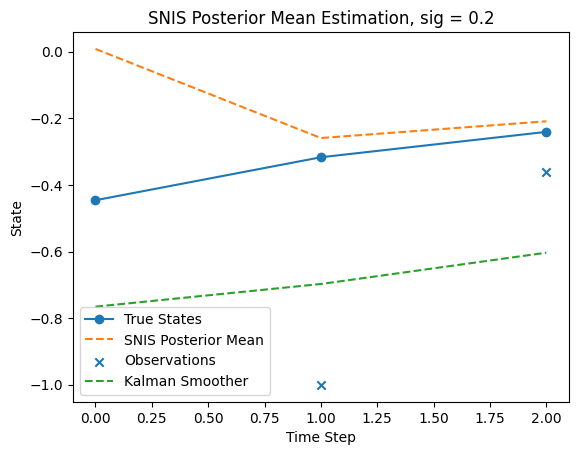

In [25]:
rng = np.random.default_rng(42)
# set small font size
plt.rcParams.update({'font.size': 10})

def SNIS(T, K, sigma_IS, m0=0, P0=1, A=0.9, Q=0.01, H=1, R=0.1):
    '''Implement Sequential Importance Sampling for given data.'''

    x_true, y_obs = datasets[T][0], datasets[T][1]
    
    # proposal
    x_samples = rng.normal(0, sigma_IS, size=(K, T+1))
    logw = np.zeros(K)
    for i in range(K):
        logw[i] = (log_joint(x_samples[i,:], y_obs) 
                   - log_q(x_samples[i,:], sigma_IS))
    logw = logw - np.max(logw) # to avoid numerical issues
    w = np.exp(logw)/np.sum(np.exp(logw)) # normalising the weights

    # we want to dot product (K,) weights with each of the 
    # K paths, each of (T+1,) length, and return the 
    # (T+1,) length mean

    return x_true, y_obs, w.dot(x_samples), w
    

# Set parameters
T = 2  # Number of time steps
K = 10000  # Number of particles
sigma_IS = 0.2  # Proposal distribution std deviation
# I use sig = 0.2 here

x_true, y_obs, posterior_mean, _ =  SNIS(T, K, sigma_IS)

plt.plot(range(T+1), x_true, label='True States', marker='o')
plt.plot(range(T+1), posterior_mean, 
         label='SNIS Posterior Mean', linestyle='--')
plt.scatter(range(1, T+1), y_obs, label='Observations', marker='x')
plt.plot(range(T+1), m_smooths[T], 
         label='Kalman Smoother', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.legend()
plt.title(f'SNIS Posterior Mean Estimation, sig = {sigma_IS}')
plt.show()

Note I use sig = 0.2 here

Increasing sig to around 0.7 will move the SNIS estimate closer to the Kalman smoother
by a little bit.

But later the MSE will suffer with larger T. Therefore we keep 0.2 here


We also reference from the lecture notes that 
to optimize memory usage and speed up the algo, we can use
sequential IS:


- **Sample:** $x_0^{(i)} \sim q(x_0)$ for $i = 1, \dots, N$.

- **Weight:**
  
  $$
  W_0^{(i)} = \frac{\pi_0(x_0^{(i)})}{q(x_0^{(i)})},
  $$

  for $i = 1, \dots, K$.

- **For** $n = 1, \dots, T$ **do**
  - **Sample:** $x_n^{(i)} \sim q(x_n | x_{n-1}^{(i)})$ for $i = 1, \dots, N$.
  - **Weight:**
    
    $$
    W_n^{(i)} = \frac{\tau_n(x_n^{(i)} | x_{n-1}^{(i)}) g_n(y_n | x_n^{(i)})}{q(x_n^{(i)} | x_{n-1}^{(i)})} W_{n-1}^{(i)},
    $$

    for $i = 1, \dots, K$.

  - Compute

    $$
    w_n^{(i)} = \frac{W_n^{(i)}}{\sum_{j=1}^{N} W_n^{(j)}},
    $$

    for $i = 1, \dots, K$.

- **End for**

I have also implemented SIS below, and tune sigma to be 0.2. In fact changing sigma doesn't
make a big difference in the T=2 case

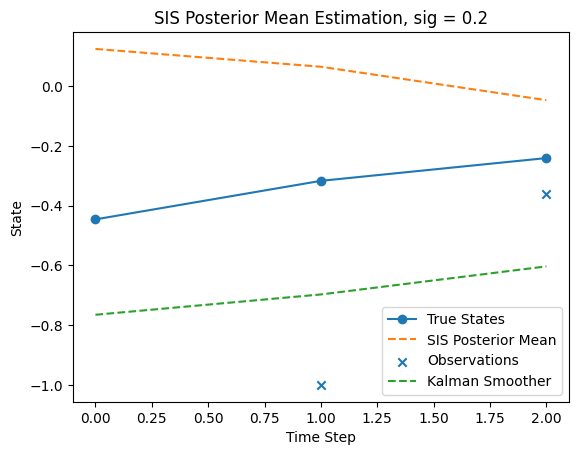

In [26]:
rng = np.random.default_rng(42)
def SIS(T, K, sigma_IS, m0=0, P0=1, A=0.9, Q=0.01, H=1, R=0.1):
    '''Implement Sequential Importance Sampling for given data.'''

    x_true, y_obs = datasets[T][0], datasets[T][1]
    
    # proposal
    x_samples = rng.normal(0, sigma_IS, size=(K, T+1))
    W = np.zeros((K, T+1))
    
    # Initial weights
    # Compute prior probability π_0(x_0) = N(m_0, P_0)
    prior_prob = (np.exp(-0.5 * ((x_samples[:, 0] - m0) ** 2) / P0) 
                / np.sqrt(2 * np.pi * P0))

    # Compute proposal probability q(x_0) = N(0, σ_IS^2)
    proposal_prob = (np.exp(-0.5 * (x_samples[:, 0] ** 2) /sigma_IS**2) 
                    / np.sqrt(2 * np.pi * sigma_IS**2))

    # Compute unnormalized weights
    W[:, 0] = prior_prob / proposal_prob
    logW = np.log(W[:, 0]) # (K, ) log weight

    # Sequential importance sampling loop
    for n in range(1, T+1):
        # Sample from the proposal distribution q(x_n | x_n-1)
        x_samples[:, n] = rng.normal(0, sigma_IS, size=K)
        
        # Compute transition probability τ_n(x_n | x_n-1)
        log_tau = log_transition(x_samples[:, n], A, Q)

        # Compute likelihood g_n(y_n | x_n)
        log_g = log_observation(y_obs[n-1], x_samples[:, n], H, R)
        
        log_proposal = log_q(x_samples[:, n], sigma_IS)

        logW += log_tau + log_g - log_proposal
        
        logW -= np.max(logW)  # Avoid overflow
        W[:, n] = np.exp(logW - np.log(np.sum(np.exp(logW))))  # Normalize in log-space
        # Compute importance weights
        # W[:, n] = np.exp(log_tau + log_g - log_proposal) * W[:, n-1]
        
        # Normalize weights
        W[:, n] /= np.sum(W[:, n])
    
    # Compute posterior mean estimate
    posterior_mean = np.sum(W[:, -1][:, np.newaxis] * x_samples, axis=0)
    w = W[:, -1]

    
    return x_true, y_obs, posterior_mean, w


# Set parameters
T = 2  # Number of time steps
K = 10000  # Number of particles
sigma_IS = 0.2  # Proposal distribution std deviation

x_true, y_obs, posterior_mean, _ =  SIS(T, K, sigma_IS)

plt.plot(range(T+1), x_true, label='True States', marker='o')
plt.plot(range(T+1), posterior_mean, 
         label='SIS Posterior Mean', linestyle='--')
plt.scatter(range(1, T+1), y_obs, label='Observations', marker='x')
plt.plot(range(T+1), m_smooths[T], 
         label='Kalman Smoother', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.legend()
plt.title(f'SIS Posterior Mean Estimation, sig = {sigma_IS}')
plt.show()

From T = 2 plot, we can notice SIS is somewhat close to the smoother, which is closer to the true states. But not much can be said with three datapoints.

Since SIS and SNIS give very different results, we visualize them for some T,
namely T = 5, 10, 15 

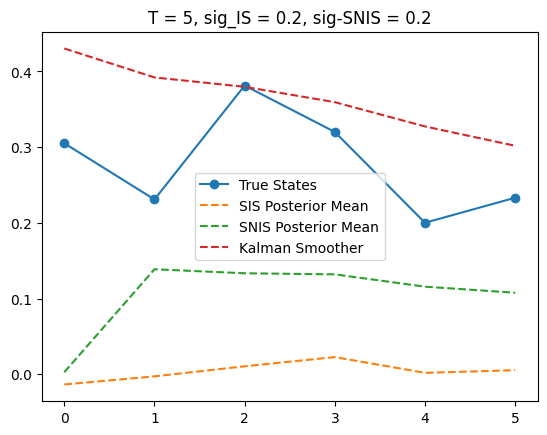

In [27]:
T = 5

sigma_IS = 0.2  # Proposal distribution std deviation
sigma_SNIS = 0.2
x_true, y_obs, posterior_mean, _ =  SIS(T, K, sigma_IS)
x_true, y_obs, posterior_mean_SNIS, _ =  SNIS(T, K, sigma_SNIS)
plt.plot(x_true, label='True States', marker='o')
plt.plot(posterior_mean, 
        label='SIS Posterior Mean', linestyle='--')
plt.plot(posterior_mean_SNIS,
        label='SNIS Posterior Mean', linestyle='--')
plt.plot(m_smooths[T], 
        label='Kalman Smoother', linestyle='--')
plt.title(f'T = {T}, sig_IS = {sigma_IS}, sig-SNIS = {sigma_SNIS}')
plt.legend()

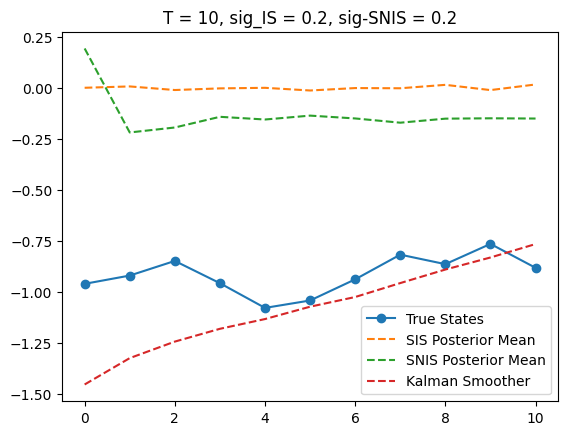

In [28]:
T = 10
x_true, y_obs, posterior_mean, _ =  SIS(T, K, sigma_IS)
x_true, y_obs, posterior_mean_SNIS, _ =  SNIS(T, K, sigma_SNIS)
plt.plot(x_true, label='True States', marker='o')
plt.plot(posterior_mean, 
        label='SIS Posterior Mean', linestyle='--')
plt.plot(posterior_mean_SNIS,
        label='SNIS Posterior Mean', linestyle='--')
plt.plot(m_smooths[T], 
        label='Kalman Smoother', linestyle='--')
plt.title(f'T = {T}, sig_IS = {sigma_IS}, sig-SNIS = {sigma_SNIS}')
plt.legend()

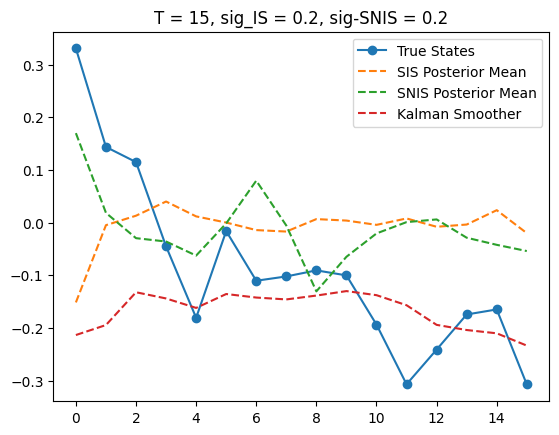

In [29]:
T = 15 
x_true, y_obs, posterior_mean, _ =  SIS(T, K, sigma_IS)
x_true, y_obs, posterior_mean_SNIS, _ =  SNIS(T, K, sigma_SNIS)
plt.plot(x_true, label='True States', marker='o')
plt.plot(posterior_mean, 
        label='SIS Posterior Mean', linestyle='--')
plt.plot(posterior_mean_SNIS,
        label='SNIS Posterior Mean', linestyle='--')
plt.plot(m_smooths[T], 
        label='Kalman Smoother', linestyle='--')
plt.title(f'T = {T}, sig_IS = {sigma_IS}, sig-SNIS = {sigma_SNIS}')
plt.legend()

### Running SNIS for all T

Note to measure sampler performance, we record ESS (effective sample size) and NMSE (normalized mean squared error)

$$
\text{ESS}(w) = \frac{1}{||w||^2}
$$

$$
\text{NMSE}(T) = \frac{|| \overline{m} - m ||^2}{||m||^2}
$$

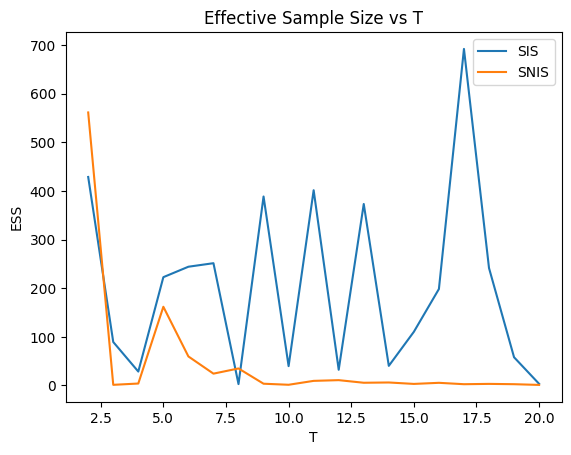

In [30]:
def ESS(w): # To measure sample quality
    return 1/np.sum(w**2)

sigma_IS = 0.2
sigma_SNIS = 0.2
ESS_SIS = []
ESS_SNIS = []
NMSE_SIS = []
NMSE_SNIS = []
for T in range(2, 21):
    x_true, y_obs, posterior_mean_SNIS, w_SNIS =  SNIS(T, K, sigma_SNIS)
    x_true, y_obs, posterior_mean, w_SIS =  SIS(T, K, sigma_IS) 

    ESS_SIS.append(ESS(w_SIS))
    ESS_SNIS.append(ESS(w_SNIS))
    nmse_SIS = (np.sum((m_smooths[T] - posterior_mean)**2) 
            / np.linalg.norm(m_smooths[T])**2
)
    nmse_SNIS = (np.sum((m_smooths[T] - posterior_mean_SNIS)**2)
            / np.linalg.norm(m_smooths[T])**2
)
    NMSE_SIS.append(nmse_SIS)
    NMSE_SNIS.append(nmse_SNIS)


plt.plot(range(2, 21), ESS_SIS, label='SIS')
plt.plot(range(2, 21), ESS_SNIS, label='SNIS')
plt.xlabel('T')
plt.ylabel('ESS')
plt.title('Effective Sample Size vs T')
plt.legend()
plt.show()

We notice that given K = 10000, both SIS and SNIS suffer from weight degeneracy,
with a small number of particles dominating. 

SNIS has a fair ESS for small T, but quickly deteriorates to a very low level (less than 0.1% of K) and stay there. SIS has some more fluctuations in terms of ESS for larger T.

But both stay below 1000 for T > 5, which is 1/10 of K.

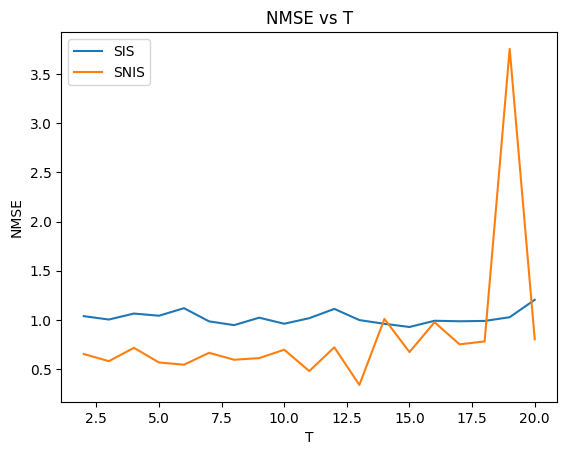

In [31]:
plt.plot(range(2, 21), NMSE_SIS, label='SIS')
plt.plot(range(2, 21), NMSE_SNIS, label='SNIS')
plt.legend()
plt.xlabel('T')
plt.ylabel('NMSE')
plt.title('NMSE vs T')
plt.show()

Again we notice both demonstrate a fairly small NMSE, with the MSE being roughly as large as the squared norm of the smoother estimate. 

There are some fluctuations of around 60% for both, with SIS having a higher NMSE for most T (this may change if I re-run many times)

The increasing trend is more obvious for SNIS than for SIS, but we can conclude from the ESS plot that larger T make estimating expectations harder,
and in general should increase MSE, due to weight degeneracy. 

Expectation estimation gets harder with larger state-space dimensions.

SIS would use tau as a proposal hence would obtain better results. NMSE results are typically worse for SNIS.